# Model development


## Policy

We assume that $A = \{a_{0}, a_{1}\}$, we further define $a_{0}$ as "deny credit" and $a_{1}$ as "offer credit". We also know from the project text that the utility function is assumed to be linear. This implies that among $E(utility|a_{i})$ and $E(utility|a_{j})$, we will always choose action $a_{i}$ over action $a_{j}$ if $E(utility|a_{i}) > E(utility|a_{j})$ adapted from (Dimitrakakis, 2020, p. 48). We will "blindly" choose the action that maximizes expected utility.

## Utility function

There are two possible actions that we could perform: $\{a_{0}, a_{1}\}$. We also have the following rewards, which are defined as possible outcomes for the bank (Dimitrakakis, 2020, p. 47). In our case these rewards are $\{-m, 0, m((1 + r)^{n} - 1)\}$. Further there are two possible actions for the bank when it comes to deciding for each new customer if they will be granted credit.

Further, we will use the definition of expected utility
$$
E[U|a_{t} = a] = \sum_{r} U(r)Pr(r|a_{t} = a)
$$
adapted from (Dimitrakakis, 2020, p. 48). This will be used for each action to calculate its expected utility. We can further define the rewards as $r_{0} =$ "the debtor defaults" and $r_{1} =$ "the debtor does not default". If we use the assumption that the utility function is linear, we can say that $U(r)$ is proportional to $r$.

### Grant credit

If we decide to grant credit ($a_{t} = 1 $) we have the following expected utility considering the rewards above:
$$
E[U|a_{t} = 1] = U(r = r_{0})Pr(r = r_{0}|a_{t} = 1) + U(r = r_{1})Pr(r = r_{1}|a_{t} = 1) 
$$
which becomes
$$
E[U|a_{t} = 1] = -m \cdot Pr(r = r_{0}|a_{t} = 1) + m((1 + r)^{n} - 1) \cdot Pr(r = r_{1}|a_{t} = 1)
$$
In our code, we have defined $Pr(r = r_{1}|a_{t} = 1)$ as the variable "p_c" and $Pr(r = r_{0}|a_{t} = 1)$ as 1-"p_c".

### Do not grant credit

If we decide not to grant credit ($a_{t} = 0 $).

$$
E[U|a_{t} = 0] = 0 \cdot Pr(r = r_{0}|a_{t} = 0) + 0 \cdot Pr(r = r_{1}|a_{t} = 0) = 0
$$



## Expected utility

If we do not give out the loan, the expected utility is $0$, as there is nothing to gain or loose. If we give a loan there are two possible outcomes; either they are able to pay it back with interest, or we loose the investment $m$. We can therefor write the expected utility if we give a loan as:
$$E(U(x) | a = a_\text{loan}) = m[(1+r)^n - 1] Pr(r = r_{1}|a_{t} = 1) - m Pr(r = r_{0}|a_{t} = 1),$$
where $Pr(r = r_{1}|a_{t} = 1)$ is the probability of paying back the loan with interest and $Pr(r = r_{0}|a_{t} = 1)$ is the probability of loosing the investment $m$.

In [1]:
def expected_utility(self, x, action):
    """Calculate expected utility using the decision maker model.

    Args:
        x: A new observation.
        action: Whether or not to grant the loan.
    
    Returns:
        The expected utility of the decision maker.
    """
    if action == 0:
        return 0

    r = self.rate
    p_c = self.predict_proba(x)

    # duration in months
    n = x['duration']
    # amount
    m = x['amount']

    e_x = p_c * m * ((1 + r) ** n - 1) + (1 - p_c) * (-m)
    return e_x

## Fitting a model

We chose to use a logistic regression model. It predicts the probability of a binary categorical variable beeing 1. A fresh random state is also given to the model for reproducable results.

In [2]:
def fit(self, X, y):
    """Fits a logistic regression model.

    Args:
        X: The covariates of the data set.
        y: The response variable from the data set.

    Notes:
        Using logistic regression, adapted from 
        https://scikit-learn.org/stable/modules/generated/sklearn.
        linear_model.LogisticRegression.html
    """
    self.data = [X, y]

    log_reg_object = LogisticRegression(random_state=1, max_iter=2000)
    self.model = log_reg_object.fit(X, y)

def predict_proba(self, x):
    """Predicts the probability for [0,1] given a new observation given the 
    model.

    Args:
        x: A new, independent observation.
    Returns:
        The prediction for class 1 given as the second element in the
        probability array returned from the model.
    """
    x = self._reshape(x)
    return self.model.predict_proba(x)[0][1]

def _reshape(self, x):
    """Reshapes Pandas Seris to a row vector.

    Args:
        x: Pandas Series.

    Returns:
        A ndarray as a row vector.
    """
    return x.values.reshape((1, len(x)))

When reading the data we one hot encode all the catagorical variables which means that they loose the information in the order. This could be fixed by instead giving them an integer value, but then we assume a linear relationship between the order of the categories.

## Best action

The best action is the action that gives the highest utility. In the event of the utilities beeing equal, we chose to not give a loan. Because of the linear utility of the investor it does not matter what we do in this situation, but we figured it is better to not accept unnecessary variability.

In [3]:
def get_best_action(self, x):
    """Gets the best action defined as the action that maximizes utility.

    Args:
        x: A new observation.
    Returns:
        Best action based on maximizing utility.
    """
    expected_utility_give_loan = self.expected_utility(x, 1)
    expected_utility_no_loan = self.expected_utility(x, 0)

    if expected_utility_give_loan > expected_utility_no_loan:
        return 1
    else:
        return 0

# Testing the model against random model

In [4]:
%matplotlib inline

import random_banker
import group1_banker
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(24092020)

features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign', 'repaid']

data_raw = pd.read_csv("german.data",
                 delim_whitespace=True,
                 names=features)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking account balance  1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   credit history            1000 non-null   object
 3   purpose                   1000 non-null   object
 4   amount                    1000 non-null   int64 
 5   savings                   1000 non-null   object
 6   employment                1000 non-null   object
 7   installment               1000 non-null   int64 
 8   marital status            1000 non-null   object
 9   other debtors             1000 non-null   object
 10  residence time            1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other installments        1000 non-null   object
 14  housing                  

## Transforming the data

In [5]:
numeric_variables = ['duration', 'age', 'residence time', 'installment',
             'amount', 'persons', 'credits']
data = data_raw[numeric_variables]

# Mapping the response to 0 and 1
data["repaid"] = data_raw["repaid"].map({1:1, 2:0})

<ipython-input-5-ad017a9a2f47>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["repaid"] = data_raw["repaid"].map({1:1, 2:0})


In [6]:
# Create dummy variables for all the catagorical variables
not_dummy_names = numeric_variables + ["repaid"]
dummy_names = [x not in not_dummy_names for x in features]
dummies = pd.get_dummies(data_raw.iloc[:,dummy_names], drop_first=True)
data = data.join(dummies)

## Testing decision makers

In [7]:
def utility_from_obs(predicted_decision, true_decision, amount, duration, interest_rate):
    """Calculates utility from a single observation.

    Args:
        predicted_decision: the model's best action
        true_decision: if the observation repaid or not
        amount: the lending amount
        duration: the number of periods
        interest_rate: the interest rate of the loan

    Returns:
        The utility from the single observation given our action.
    """
    if predicted_decision == 1:
        if true_decision == 1:
            return amount*((1 + interest_rate)**duration - 1)
        else:
            return -amount
    else:
        return 0

In [8]:
def utility_from_test_set(X, y, decision_maker, interest_rate):
    """Calculates total utility from a given test set.

    Args:
        X: the covariates of the test set
        y: the response variable of the test set
        decision_maker: the decision maker to use in order to calculate utility
        interest_rate: the interest rate to use when calculating utility

    Returns:
        The sum of utility from the test set and the sum of utility divided by
        total amount.
    """

    num_obs = len(X)
    obs_utility = np.zeros(num_obs)
    obs_amount = np.zeros_like(obs_utility)

    for new_obs in range(num_obs):
        predicted_decision = decision_maker.get_best_action(X.iloc[new_obs])
        true_decision = y.iloc[new_obs]

        amount = X['amount'].iloc[new_obs]
        duration = X['duration'].iloc[new_obs]

        obs_utility[new_obs] = utility_from_obs(
            predicted_decision, true_decision, amount, duration, interest_rate)
        obs_amount[new_obs] = amount

    return np.sum(obs_utility), np.sum(obs_utility)/np.sum(obs_amount)

In [9]:
def compare_decision_makers(num_of_tests, response, interest_rate):
    """Tests the random banker against our group1 banker.

    Args:
        num_of_tests: the number of tests to run
        response: the name of the response variable
        interest_rate: the interest rate to use when calculating utility
    """
    bank_utility_random = np.zeros(num_of_tests)
    bank_investment_random = np.zeros_like(bank_utility_random)
    bank_utility_group1 = np.zeros(num_of_tests)
    bank_investment_group1 = np.zeros_like(bank_utility_group1)

    results = {}

    # decision makers
    r_banker = random_banker.RandomBanker()
    r_banker.set_interest_rate(interest_rate)
    n_banker = group1_banker.Group1Banker()
    n_banker.set_interest_rate(interest_rate)

    # get data
    X = data
    covariates = X.columns[X.columns != response]

    for i in range(num_of_tests):
        X_train, X_test, y_train, y_test = train_test_split(
            X[covariates], X[response], test_size=0.2)

        # fit models
        r_banker.fit(X_train, y_train)
        n_banker.fit(X_train, y_train)

        bank_utility_random[i], bank_investment_random[i] = utility_from_test_set(
            X_test, y_test, r_banker, interest_rate)
        bank_utility_group1[i], bank_investment_group1[i] = utility_from_test_set(
            X_test, y_test, n_banker, interest_rate)

    results["utility_random_banker"] = bank_utility_random
    results["investment_random_banker"] = bank_investment_random
    results["utility_group1_banker"] = bank_utility_group1
    results["investment_group1_banker"] = bank_investment_group1

    return results
    


In [10]:
%%time
response = 'repaid'
results = pd.DataFrame(compare_decision_makers(100, response, 0.05))

CPU times: user 42.8 s, sys: 322 ms, total: 43.2 s
Wall time: 22.7 s


In [11]:
results.describe()

,utility_random_banker,investment_random_banker,utility_group1_banker,investment_group1_banker
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,5.922753e+05,0.913618,1.180550e+06,1.825611
std,1.995408e+05,0.296520,2.872515e+05,0.423820
min,1.715205e+05,0.270745,6.235157e+05,0.971803
25%,4.595768e+05,0.692373,9.772184e+05,1.476474
50%,5.880903e+05,0.913637,1.181998e+06,1.817679
75%,7.179540e+05,1.119127,1.364043e+06,2.091771
max,1.191101e+06,1.889368,2.137712e+06,3.053918


Text(0, 0.5, 'Density')

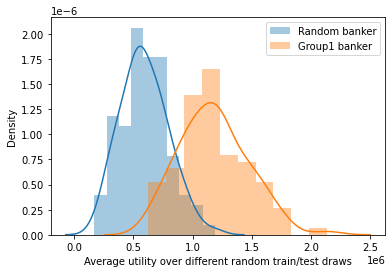

In [12]:
sns.distplot(results["utility_random_banker"], label="Random banker")
sns.distplot(results["utility_group1_banker"], label="Group1 banker")
plt.legend()
plt.xlabel("Average utility over different random train/test draws")
plt.ylabel("Density")

## Results

Based on 100 random train/test splits, our model using logistic regression is considerably better than the random model.

# Questions: reproducibility, reliability and privacy

### Is it possible to ensure that the policy maximises revenue?

We cannot ensure with 100 % certainty that the policy maximises revenue. This is due to the fact that the model is not perfect and we are maximising the expected utility. There is an uncertainty in the estimated probability of a new individual being credit-worthy. If there were no uncertainty in this and we knew in advance which of the new individuals were going to pay back, we could ensure that a policy would maximise revenue by only lending to the credit-worthy individuals.

### How can we take into account the uncertainty due to limited/biased data?

In an ideal world we would have an independent replication of our study and check whether or not new, independent data would develop the same type of policy that we obtained with the current data set. Another option is simulation of data in order to validate our policy based on constructed data (Dimitrakakis, 2020, pp. 35-36). When it comes to the current policy, there are several ways of taking this uncertainty into account when considering our objective of maximising expected utility.

### What are the consequences if the model is wrong?

There will always be a possibility that the model performs a lot worse in practice. For example our data set could be a bad representation of the population because of some change in the population properties after it was collected. Therefore it is important not to put too much trust into new models. Simple interpretable models have a clear advantage in this regard. If the model is simple enough you might spot errors before the model is tested in practice, and if you find a model to be wrong, it will be easier to understand why.

For the bank, one of the major consequences of the model being wrong is the loss of profit. If the model is granting credit too easily, the bank could incur losses due to the fact that they are granting credit and then loosing the entire investement $m$. If the model is too strict about granting credit, the bank is missing potential profit from the individuals that were declined credit, this would be $-m((1+r)^n - 1)$. The missed potential income could also cause the individuals that were wrongfully declined credit to apply for credit elsewhere. In that case, a hard-to-intepret model would also increase the difficulty in troubleshooting the reasons for the wrongfully decline of credit.

### How can we take into account the risk of the model being wrong?

It is possible to consider the two types of error the model can generate: 

1. classify new individuals as credit-worthy when they are in fact not ($a_{10}$)
2. classify new individuals as not being credit-worthy when they in fact are ($a_{01}$)

We can indicate the class of actual credit-worthy individuals as 'positive' ($a_{1}$) and the class of individuals not being credit-worthy as 'negatives' ($a_{0}$). Then our error (1) can be called a false positive and the other type of error (2) as a false negative. This corresponds to type 1 and type 2 erros, where the probability of type 1 errors is equivalent to the probability of false positive and type 2 error is equivalent to the probability of false negative. These probabilities can be estimated by looking at the fraction $\frac{a_{10}}{\# a_{1}}$. Similarily for the false negatives $\frac{a_{01}}{\# a_{0}}$. Adapted from (Azzalini & Scarpa, 2012, p. 139). For our example, if a new individual is classified as credit-worthy and this is a false positive, it implies the loss $-m$ (the lost investment). While if a new individual is classified as not being credit-worthy and this is a false negative, it implies the loss of $-m[(1+r)^{n} - 1]$ (the "lost" return on investment). 

The different actions are weighted by their reward values, so the decision maker grants credit based on the reward-weighted utility, not only whether or not the probability of repayment is above a threshold, such as $>0.5$. These weights are shown below:

|   |           |            | True              |         |
|---|-----------|------------|-------------------|---------|
|   |           |            | No default        | Default |
|   | Predicted | No default | $-m((1+r)^n - 1)$ | $-m$    |
|   |           | Default    | 0                 | 0       |


We could take into account the risk of the model being wrong by trying to control the type 1 error (false positive), we want to minimize false positives because this causes us to lose -m. We could enfore a higher threshold than 0 for the expected utility and then we could check this by demanding that the probability for type 1 errors (false positive) should be within an accepted range, e.g. maximum 5 %. We could attempt to find this threshold for type 1 erros by looking at the training data and check the probability for type 1 errors on a holdout set of the training data. Currently, we are attempting to control this by increasing the threshold for which to grant credit. When increasing the threshold for the expected utility, the model becomes more conservative. This would be equivalent to saying that we need to be for example $\ge$ 75 % sure that the loan is going to be repaid rather than just $\ge$ 50 % sure that the loan is going to be repaid in a situation where we only looked at the probability of repayment.

We would want to have the percentage of false positives to be below a limit, e.g. $max\_alpha = Pr(\text{false positive}) = 0.05$ 

An outline of the algorithm:

1. initialize $\epsilon = 0$, $alpha\_value = 1$ and $\Delta \epsilon = 1000$
2. while $alpha\_value \ge max\_alpha$:
    * false_positives = 0
    * predicted_actions = get_actions(validation_data, $\epsilon$)
    * false_positives += get_number_of_false_positives(predicted_actions, validation_data)
    * $alpha\_value$ = false_positives/len(validation_data)
    * $\epsilon = \epsilon + \Delta \epsilon$
3. alter policy so that $E(U(\cdot)) > \epsilon$ in order to grant credit to an individual 



### Does the existence of the database raise any privacy concerns?

The database is anonymized because there are no directly identifying attributes about the individuals (Dimitrakakis, 2020, p. 74). However, there is very specific information about the individuals in the database, such as age, personal status, sex and information about the employement situation of the individuals. There is also information about the housing and property situation of the different individuals.

There seems to be a high probability of inferring personal information about the individuals in the database by using for example record linkage. When considering differential privacy, it could be useful to assume that the adversary has potentially infinite side information (Dimitrakakis, 2020, p. 76). Where side information could be defined as information that an adversary has about all, except one observation of a dataset (A). We can call these datasets A and A’. The idea of differential privacy is then that even in the extreme case that the adversary has all this information, they should not be able to infer information about the missing observation based on differential private queries on A and A’ (Zhu, 2017, pp. 7-8). Unlimited access to this database could therefore be a large privacy concern. Both because adversaries could use side information to infer information from this database and/or because adversaries could use this database as side information to infer information from other databases. 

If we have the datasets A and A’ as above, an algorithm called ALG and define f(ALG(*)) as the probability distribution of the result. Then differential privacy could be defined as

$$
f(ALG(A)) < e^{\epsilon}f(ALG(A’)) + \delta
$$

where $\delta = 0$ for $\epsilon$-DP. The parameter $\epsilon$ here controls the degree of equality between the distributions, adapted from (Le Ny, 2020, pp. 5-6). Based on this definition it would seem that by decreasing $\epsilon$, the two distributions for the different algorithms would be more similar.

### How would secret database and public credit decisions affect privacy?

It would obviously be better to have the database secret instead of the database also being public. It could however be possible to infer a lot of information from the secret database by knowing the public credit decision. 

Because the bank is publishing the actual credit decisions, differential privacy is not possible. If, for example, an adversary with information about all but one attribute for a specific row, the adversary could infer the information of the missing attribute by using the public credit decisions. If the credit decisions were to be made public, the bank would have to consider the fact that adversaries could query the public “database” containing the credit decisions. This information could then be used as side information or together with additional side information to infer information about the individuals. 

One way to ensure privacy of the credit decision would be the “randomised response mechanism”. In this response mechanism, the true credit decision would be returned with probability p0 = 0.5 and with probability, p0’ = 1 – p0, the response mechanism would return 1 with probability 0.5 and 0 with probability 0.5. This calculation of the response could then be independent for each query (Dimitrakakis, 2020, p. 77). To ensure differential privacy for the public credit decisions, this algorithm could be implemented when potential adversaries queries the public “database”.

### How can we protect the data of the people in the training set?

We could use differential privacy to obscure the information in the public credit decisions that have been made by the bank.

* if the database is secret, but the credit decisions are public (we assume that the identities of the individuals also are public): we would have a randomised response mechanism for the credit decision. This randomised response mechanism will ensure that the public responses are correct with a probability $\le 1$ (Dimitrakakis, 2020, p. 77). This would make it harder to infer information about the individuals from the public information. Even if the database is not public, there is a risk of dishonest employees and/or digital attacks on the bank.

The training data contains several columns of attributes. We could implement a mechanism where each of the attributes would be transformed independently and then the entire observation (with all attributes) could be returned (Dimitrakakis, 2020, p. 82). For categorical columns of the training data, it would be possible to implement a randomised response mechanism as above. For the numerical it would be possible to use a Laplace mechanism in order to transform the response by adding a Laplace-distributed noise parameter to the returned true value. This could be done by adding Laplace-distributed noise to each variable before computing a response, which would be a local privacy model (Dimitrakakis, 2020, p. 83). In order to protect the training data w.r.t. privacy the following outline of an algorithm could be implemented

1.	Add Laplace-noise to numerical attributes
2.	Add randomized response mechanism to categorical attributes

* if the database is public and the credit decisions are public: for categorical attributes, we could use a randomised response mechanism. For the numerical attributes, we can apply a Laplace mechanism in order to make the information differentially private. In this scenario as well, the bank is still vulnerable to dishonest employees and digital attacks as the original (true) data is still available inside the bank.

One could also have performed randomized response mechanism for the credit decision of the training data if this was the only data that would be public (and would have needed protection). In that case one would have a situation more similar to a centralized privacy model when adversaries query the data. Because one could for example calculate the true number of accepted credit applications and then add noise before returning the response (Dimitrakakis, 2020, p. 83). This would protect the data of the people in the training set because an adversary would lose the ability to infer information with the credit decision as side-information.

### How can we protect the data of the people that apply for loans?

We assume that the data for a new individual could potentially be leaked and considered non-secret. In that case we could apply the same techniques as for people in the training set. We would then apply a random mechanism to the input data for the new applicant. This could be done in the same manner as for the training data. There would be two possible scenarios:

1.	Protect the data by adding Laplace-noise to numerical attributes and using the randomized response mechanism for the categorical attributes
2.	Protect the data by adding noise to the response variable after the policy has made the decision on the true data of the new test data. This would be a type of centralized privacy model as mentioned above where the noise is added after the calculations

### Implement a private decision making mechanism for people that apply for new loans

Our implementation is listed in the appendix at the end of the report.

The plot shows average loss of utility over differnt train/test splits for different values of lambda in the laplace noise.
The results are unexpected beacuse it seems that the utility does not get significantly worse for higher values of lambda.

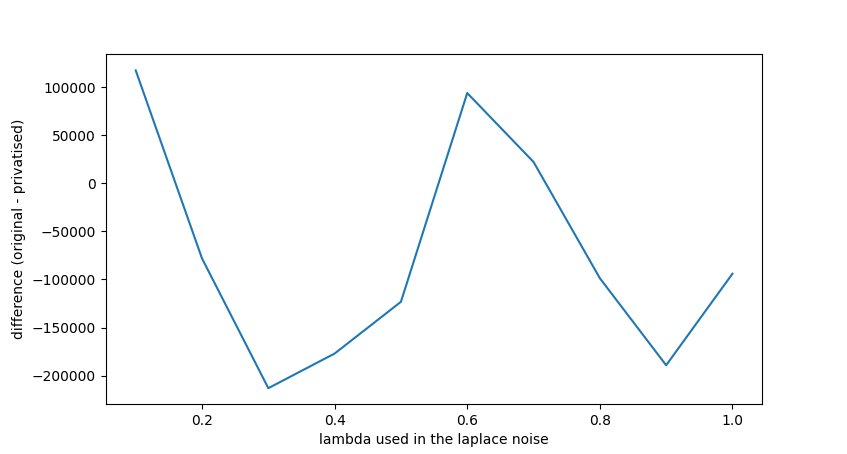

In [1]:
from IPython.display import display
from PIL import Image
path="img/privacy_guarantees.png"
display(Image.open(path))

### Estimate the amount of loss in utility as we change the privacy guarantee

The amount of loss in utility is related to privacy. More privacy in general indicates less expected utility as more information is “lost” when the policy is deciding the best action. In order to estimate the loss in utility one can base the estimation of (alpha, beta) usefulness for an algorithm A, an algorithm with more privacy as A_hat and the (test) data set TD that is defined through Pr(|A(TD) – A_hat(TD)| <= alpha) > 1 – beta. A small difference between the algorithm and the privacy modified algorithm would imply a small loss in utility (Zhu, 2017, pp. 15-16). This would be one possible estimate of the loss in utility, while the absolute difference |U(TD) – U_hat(TD)| itself could be another estimate of loss in utility where U is the normal utility and U_hat is the utility with increased privacy.

### How will the interest rate affect the decision maker(s)?

The interest rate $r$ affects the action of the decision maker through the expected utility. The expected utility given that the credit application is granted, $a_{t}=1$ is defined as:

$$
E[U|a_{t} = 1] = -m \cdot Pr(r = r_{0}|a_{t} = 1) + m((1 + r)^{n} - 1) \cdot Pr(r = r_{1}|a_{t} = 1)
$$

This further implies that the interest rate only affects the reward where the debtor does not default. This reward defines the utility:

$$
m((1 + r)^{n} - 1)
$$

From this we see that increasing interest rate when investment $m$ and the number of periods $n \ge 1$ are held constant will monotonically increase the expected utility with increasing interest rate. For the decision maker this would mean that the probability for repayment of the credit: $Pr(r = r_{1}|a_{t} = 1)$ could be lower and the decision maker would still accept the credit application.

### How will the number of periods affect the decision maker(s)?

For the number of periods, the situation is the same as above, the expected utility will increase monotonically with increasing $n$ as long as $r > 0$. This is also logical because the bank would increase its profit with the number of interest rate accruals from the loan.

### What are two main ways to perturbate the data in order to protect the individuals of the data set?

There seems to be two possible mechanism to use in order to protect the individuals of the datasets. These are input perturbation and output perturbation. The input perturbation would add differently distributed types of noise to the columns of the data in order to protect the private information. Output perturbation would use “secret” data in the algorithm and then add noise to the output of that algorithm (Le Ny, 2020, pp. 18-22). These ways correspond to adding noise directly to the columns of the data sets before predicting the best action as an input perturbation. If we would calculate the best action based on the private data and then obtain our “true” credit decision we could add noise to this output we would have a mechanism closer to the output perturbation.

# Questions: fairness

In order to simplify notation, we define the following variables in the same manner as in (Dimitrakakis, 2020, pp. 103-104): 
* y: {1: the credit was repaid, 0: the credit was not repaid (default)}
* a: {1: the application was accepted, 0: the application was rejected}
* x: covariates
* z: sensitive covariates

## Guiding questions

### Identify sensitive variables

There are several variables in the data set that could potentially be considered sensitive. Variables such as the 9th covariate “Personal status and sex” could be considered sensitive. Because ceteris paribus we would ideally have that the chance of being offered credit should be the same whether the applicant is e.g. a married male or a single female. 
Covariate 11 “present residence since” could also be considered sensitive, since we generally do not want to discriminate w.r.t. this because we cannot determine the reason for the change of residency.

Covariate 13 “age” could also potentially be considered sensitive because, as with gender and personal status, we do not want to discriminate the credit decision upon age. Although we could argue that age must be considered when considering the credit decision w.r.t. repayment.

Covariate 20 “foreign worker” ceteris paribus could also be discussed to be a sensitive variable. Whether or not the worker is foreign or not should ideally not affect the credit decision.

### Do the original features already imply some bias in data collection?

We can think of bias in the data collection as either what covariates where selected to be measured (bias in selecting the columns of the training set) and as what type of individuals were selected to be measured (bias in selecting the rows of the training set). The features of the data set could seem little fine grained because of the many categorical features that seems to have somewhat arbitrary thresholds for the categories. This is in the sense that there are for example categories for savings account with very different widths $(100, 400, 500 \text{ and } [\infty \ge 1000])$. This categorical would e.g. place an individual with 1000 DM in the same category as an individual with an arbitrary large amount of savings.

### Analysis of decision function

### Analysis of balance

It is important that the decision function does not discriminate against gender. To investigate how fair our model is with respect to gender, we plotted the amount of males/females that are classified as "did repay"/"didnot repay"

![im](img/gender_compare.png)

The first thing that is apparent in the plot is that our model overestimates how many that end up paying back. This is a problem, but it is not relevant to fairness.
What is relevant to fairness is the proportions of males/females that are predicted to repay. In the true data the proportions of men and women seems aproximately equal within those who repaied and those who did not. This sugests that gender should not be very relevant in predicting wether someone repayes. That is however not the case in our predicted response. Our model greatly favors males even though the true data tells us that it shouldn't.

### Analysis of calibration

### What would happen if fairness also would consider the amount of loan requested?

### Stochastic gradient descent to find a policy that balances out fairness and utility

## Summarizing questions

## How can we measure whether our policy is fair?

## How does the training data affect the fairness of the policy?

# References

Azzalini, A. & Scarpa, B. (2012). Data analysis and data mining: An introduction. Oxford: Oxford University Press.

Dimitrakakis, C. (2020). *Machine learning in science and society*. Unpublished. Department of Informatics, University of Oslo.

Le Ny, J. (2020). Differential privacy for dynamic data (1st ed. 2020, SpringerBriefs in electrical and computer engineering). Cham, Switzerland: Springer.

Zhu, T. (2017). Differential privacy and applications (1st ed 2017 ed., Vol. 69, Advances in information security). Cham, Switzerland: Springer.

# Appendix

## Differential privacy

In [ ]:
def transform_categorical(data, p):
    """ Transform a column of categorical data data with a randomised response mechanism

    Args:
        data: Array with data from a categorical attribute.
        p: The probablity of changing a datapoint.

    Returns:
        Array of the same length as the input data, containing the transformed data.
    """
    transform_indexing = rnd.choice([True, False], size=data.size, p=[p, 1-p])
    new_values = rnd.choice(np.unique(data), size=transform_indexing.sum())
    new_data = data.copy()
    new_data[transform_indexing] = new_values
    return new_data


def transform_quantitative(data, b, scale_noise=False):
    """ Transform a column of quantitative data with laplace noise

    Args:
        data: Array with the data from a quantitative attribute.
        b: Positive float used as the second parameter of the laplace distribution,
            referred to as the scale or the diversity of the distribution.
        scale_noise: If true, scale the laplace noise by the standard deviation of the data.
            This allows the same value for b to be used on differently scaled data

    Returns:
        Array of the same length as the input data, containing the transformed data.
    """
    noise = rnd.laplace(0, b, size=data.size)
    if scale_noise:
        noise *= data.std()
    return data + noise


def apply_random_mechanism_to_data(data_frame, quantitative_names, categorical_names, laplace_delta, p):
    """ Aplies a random mechanism to certain columns of a data frame

    Args:
        data_frame: A pandas data frame
        quantitative_names: An iterable with the column names of the quantitative attributes
            you wish to add laplace noise to.
        categorical_names: An iterable with the column names of the categorical attributes you
            wish to transform.
        laplace_delta: The delta parameter to supply to the laplace noise
        p: The probability to suppøy to the random noise for categorical data.

    Returns:
        Pandas data frame of the same dimentions as the one supplied, but with differentially private data.
    """
    dp_data = data_frame.copy()

    for column_name in quantitative_names:
        dp_data[column_name] = transform_quantitative(
            data_frame[column_name], b=laplace_delta, scale_noise=True)

    for column_name in categorical_names:
        dp_data[column_name] = transform_categorical(
            data_frame[column_name], p)

    return dp_data


    def get_differentially_private_data(laplace_lambda, p):
    """ Reads in the german data and applies a random mechanism

    Args:
        laplace_lambda: the lambda value to use in the laplace noise
        p: the probability of changing a categorical value

    Returns:
        Differentially private data set.
    """
    features = ['checking account balance', 'duration', 'credit history',
                'purpose', 'amount', 'savings', 'employment', 'installment',
                'marital status', 'other debtors', 'residence time',
                'property', 'age', 'other installments', 'housing', 'credits',
                'job', 'persons', 'phone', 'foreign', 'repaid']

    data_raw = pd.read_csv("german.data",
                           delim_whitespace=True,
                           names=features)

    numeric_variables = ['duration', 'age', 'residence time', 'installment',
                         'amount', 'persons', 'credits']
    categorical_variables = set(features).difference(set(numeric_variables))

    data_raw = differential_privacy.apply_random_mechanism_to_data(
        data_raw, numeric_variables, categorical_variables, 0.3, 0.4)

    data = pd.DataFrame(columns=numeric_variables)
    data[numeric_variables] = data_raw[numeric_variables]

    # Mapping the response to 0 and 1
    data["repaid"] = data_raw["repaid"].map({1: 1, 2: 0})
    # Create dummy variables for all the catagorical variables
    not_dummy_names = numeric_variables + ["repaid"]
    dummy_names = [x not in not_dummy_names for x in features]
    dummies = pd.get_dummies(data_raw.iloc[:, dummy_names], drop_first=True)
    data = data.join(dummies)

    return data


    def compare_privacy_garantees(laplace_lambdas, p, n_repeats, n_folds, response, interest_rate):
    """ Compare utility of models with differnt privacy guarantees.

    Args:
        laplace_lambdas: iterable with the different lambda values to use
        p: probability of changing a categorical variable
        n_repeats: number of repeats in the repeated cross validation
        n_folds: number of folds in k-fold cv
        response: the name of the response variable
        interest_rate: the interest rate by month to use when calculating utility

    Returns:
        Dictionary on the form {string: numpy.ndarray(shape=(nrepeats, n_folds))}
        with the results.
    """
    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    data_frames = []
    data_frames.append(get_data())
    for laplace_lambda in laplace_lambdas:
        data_frames.append(get_differentially_private_data(laplace_lambda, p))

    results = {}
    for i, data_frame in enumerate(data_frames):
        y = data_frame.pop(response)

        new_result = repeated_cross_validation_utility(
            X=data_frame, y=y,
            bankers=[g_banker],
            banker_names=[f"lambda{i}"],
            interest_rate=interest_rate,
            n_repeats=n_repeats, n_folds=n_folds)

        print(f"Done with {i}/10")

        results.update(new_result)

    return results